In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 627 Project - Shelter Animal Outcomes
- Author: Zhongyu Liu, Hollin Han, Yan Ting Chen
- Data: 10/30/2017
- Classification algorithm: RandomForest, Logistic Regression
- Objective: Use classification algorithms to process multiclass classifcation data and predict shelter outcomes.

## Section I
## Report and Analysis

In [2]:
# Load packges to prepare for the analysis
import pandas as pd # data visualization
import seaborn as sns # data visualization

In [3]:
# Read in each data
# Test and train data use to generate the final result
test = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/test.csv')
train = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/train.csv')
# Train_data is used for performance analysis
train_data = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/train.csv')
sample_sub = pd.read_csv('/Users/JohnnyLiu/Mine/User/MIAMI_UNIVERSITY/Fall_2017/CSE_627/Proj/sample_submission.csv')

In [4]:
# Help function to generate performance count probability.
# It will return the probability for each part, seperated by anaimal type.
# Such as for cats who get adopted, 10% of them are teen.
def generate_Count_Prob(table, rounds=2):
    count_p = []
    for i, c in enumerate(table.AnimalType):
        if c == 'Cat':
            count_p.append(round(float(table.Count[i]) / cat_count, rounds))
        else:
            count_p.append(round(float(table.Count[i]) / dog_count, rounds))
    return count_p

In [5]:
# Help function to generate plots for data visualization.
# Grouped by animal type and classifiers. 
def generate_plot(x, table, fs1=25, fs2=12, sp1=2, sp2=5, titles = ['Cat', 'Dog'], 
                  outcome = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']):
    figsize(fs1, fs2)
    for i in range(len(titles)):
        temp = table[table.AnimalType == titles[i]]
        for j in range(len(outcome)):
            subplot(sp1, sp2, i*5+j+1)
            title(titles[i] + '_' + outcome[j])
            ax = sns.barplot(x=x, y='Count_P', data=temp[temp.OutcomeType == outcome[j]])
            ax.set(xlabel='', ylabel='')

### Calculate Animal Count and Missing Data
Before actually start analysis, we need to check the total number for dogs and cats, so we can calculate the percentage count for each outcome type, to achieve better data visualization and future analysis. Also, we want to check how many missing data we have before start analysis.

In [6]:
# Get the total number of dog and cat in train data.
dog_count = sum(train_data.AnimalType == 'Dog')
cat_count = sum(train_data.AnimalType == 'Cat')
print 'Total Cat:', cat_count
print 'Total Dog:', dog_count

Total Cat: 11134
Total Dog: 15595


Since there's more dogs than cats, it's really important to compare their percentage result rather than just number count, which is what we gonna do later.

In [7]:
# Distribution of missing data in train data.
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

As we can see, there's tons of missing names, 1 missing sex and 18 missing ages. There's bunch of missing outcome subtype but that's something less relevant to our analysis.

Since about 30% name missing. It's not going to be valuable analysis if we analysis the name part, so we are just going to analysis is given animal have a name or not.

Compare to names, missing data in sex and age is not that significant, we are going to replace the missing sex with random one (male or female), and replace the missing age data with average.

In [8]:
# Distribution of missing data in test data.
test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

Same for test data, we got some missing data on name and age. Name part we don't need to worry about but the 6 missing age we are going to replace it again with average age.

### Analysis by Animal type

First of all, I would like to see the difference between dogs and cats by plotting, since plots are pretty self explain with corresponding labels.

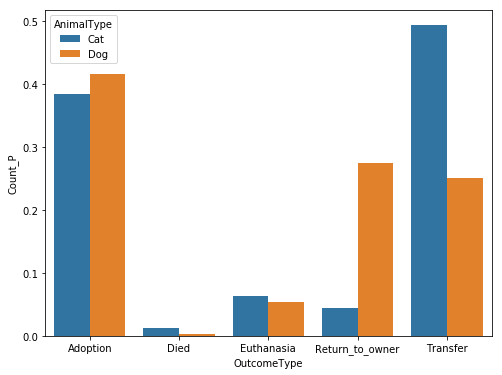

In [9]:
# Generate new train outcome groups by outcome type and calculate probability for each of them.
train_outcome = pd.DataFrame({'Count' : train_data.groupby( [ "AnimalType", "OutcomeType"] ).size()}).reset_index()
train_outcome['Count_P'] = generate_Count_Prob(train_outcome, 3)
figsize(8, 6)

sns.barplot(x="OutcomeType", y='Count_P', hue="AnimalType", data=train_outcome)

Animal type is a pretty important variables that we need to involve in the future training. As we can see, dogs and cats are commonly adopted. Same with died and euthanasia, even though they are not very many but cat have bit more percentage than dog.

Return to owner and transfer have a big difference between dogs and cats. For cat, it's more likely to get transfer, but dogs have more chance to get to return to owner.

### Analysis Age
We will seperate the animal age by the following range.
- Teen – 0-6 months.
- Junior – 6 months-2 years.
- Prime – 3-6 years.
- Mature – 7-10 years.
- Senior - 11-14 years.
- Geriatric - 15 years and over.


We get this range from wiki and for start we think we should get more detial since it might be significant for some outcome like died. Also we think maybe it's important seperate the age by just is adult or not. Since teen are more likely to get adopt and transfer but less likely to get return to owner (maybe it don't have owner yet). 

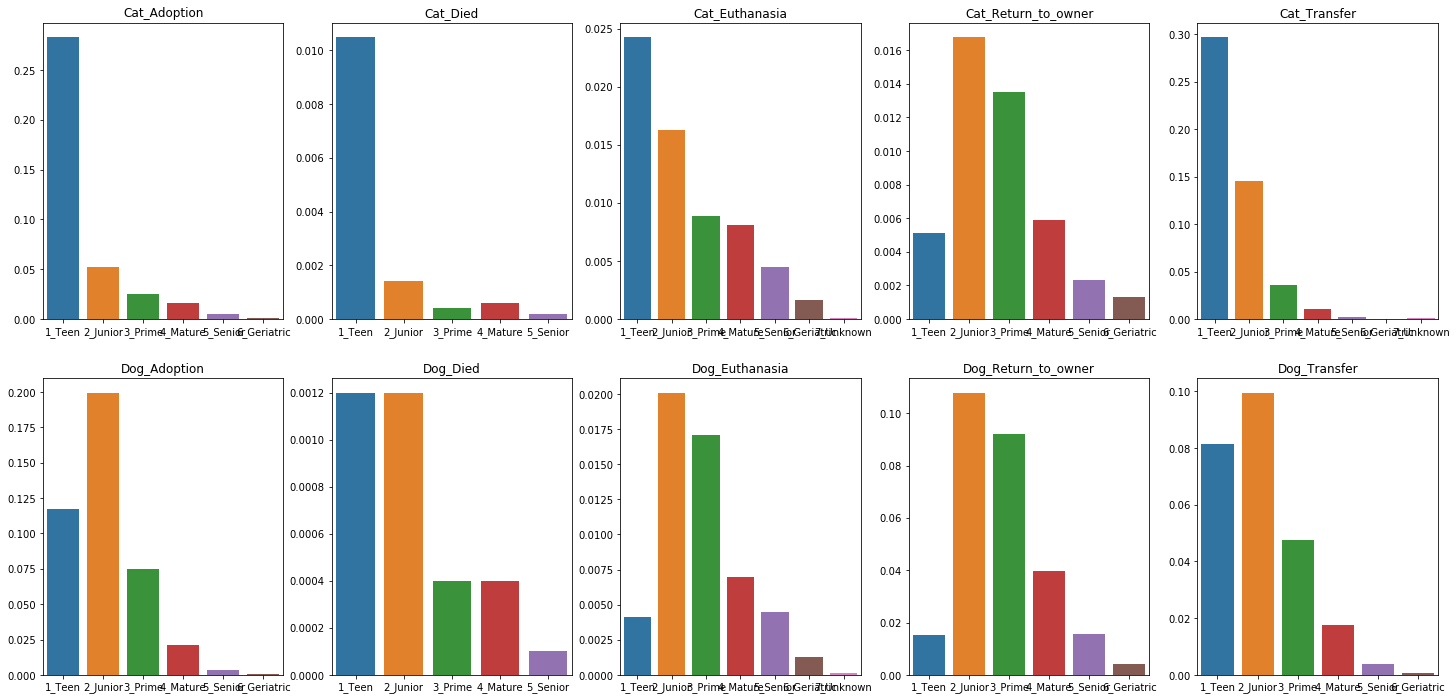

In [10]:
# Seperate by ages, basicly for plot I just used help function,
# seperate by number and month, day, week, years, 
# and put them into corresponding range, pretty stright forward.
age_type = []
for c in train_data.AgeuponOutcome:
    # To deal with missing data, since 'nan' is float type
    if type(c) == float:
        age_type.append('7_Unknown')
        continue
    c = c.split(' ')
    if c[1] == 'month' or c[1] == 'months':
        if int(c[0]) < 7:
            age_type.append('1_Teen')
        else:
            age_type.append('2_Junior')
    elif c[1] == 'year' or c[1] == 'years':
        if int(c[0]) < 3:
            age_type.append('2_Junior')
        elif int(c[0]) < 7:
            age_type.append('3_Prime')
        elif int(c[0]) < 11:
            age_type.append('4_Mature')
        elif int(c[0]) < 15:
            age_type.append('5_Senior')
        else:
            age_type.append('6_Geriatric')
    else:
        age_type.append('1_Teen')
        
train_data['LifeStage'] = age_type

train_outcome_age = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'LifeStage']).size()}).reset_index()
train_outcome_age['Count_P'] = generate_Count_Prob(train_outcome_age, 4)

generate_plot('LifeStage', train_outcome_age)

In summary, age is an important variable since there's a huge difference between the ages groups. For example, both the cats younger than 6 months and the dogs between half year and 2 years old have a higher possibility to get transferred or adopted. In the future, it would be easier to combine some of these six ranges and maybe simply check if an animal is adult (1 years old) or not.

### Analysis breed

In [11]:
# Seperate the variable of breed, with dog by size, cat by hair type to generate six groups of breed as follows:
smallDog = ["Affenpinscher","Australian Terrier","Bedlington Terr","Bichon Frise", "Border Terrier", 
                "Boston Terrier", "Cairn Terrier", "Cavalier", "Chihuahua", "Chinese Crested", "Dachshund", 
                "Havanese", "Italian Greyhound", "Jack Russell Terrier", "Japanese Chin", "Lhasa Apso", 
                "Lowchen", "Maltese", "Manchester Terrier", "Miniature Pinscher", "Miniature Schnauzer", 
                "Norwich Terrier", "Papillon", "Parson Russell Terrier", "Pekingese", "Pomeranian", "Poodle", 
                "Podengo Pequeno", "Rat Terrier", "Schipperke", "Scottish Terrier", "Shiba Inu", "Shih Tzu", 
                "Silky Terrier", "Smooth Fox Terrier", "Welsh Terrier", "West Highland", "Yorkshire Terrier"]
mediumDog = ["Afghan Hound", "Airedale Terrier", "American Eskimo", "American Foxhound", "Australian Cattle",
             "Australian Shepherd", "Basenji", "Basset Hound", "Beagle", "Bearded Collie", "Belgian Malinois", 
             "Border Collie", "Boxer", "Brittany", "Canaan Dog", "Cardigan Welsh Corgi", "Chow Chow", "Cocker Spaniel",
             "Collie", "English Bulldog", "English Pointer", "Field Spaniel", "Finnish Spitz", "German Pinscher", 
             "Glen Of Imaal", "Harrier", "Ibizan Hound", "Irish Terrier", "Keeshond", "Norwegian Elkhound", 
             "Nova Scotia Duck Tolling", "Pembroke Welsh Corgi", "Pharaoh Hound", "Plott Hound", "Coonhound", "Saluki", 
             "Samoyed", "Sealyham Terr", "Shetland Sheepdog", "Siberian Husky", "Skye Terrier", "Soft Coated Wheaten Terrier",
             "Springer Spaniel", "Standard Schnauzer", "Swedish Vallhund", "Tibetan Terrier", "Treeing Walker Coonhound", 
             "Vizsla", "Welsh Springer Spaniel", "Whippet", "Wirehaired Pointing Griff"]
largeDog = ["Inu", "Alaskan Malamute", "American Staffordshire Terrier", "Beauceron", "Bernese Mountain", "Coonhound",
            "Bloodhound", "Boerboel", "Borzoi", "Bull Terrier", "American Bulldog", "Bullmastiff", "Cane Corso",
            "Retriever", "Dalmatian", "Doberman Pinsch", "Dogo Argentino", "English Foxhound", "English Setter", 
            "Flat Coat Retriever", "German Pinscher", "German Shepherd", "German Shorthair Pointer", 
            "German Wirehaired Pointer", "Schnauzer Giant", "Golden Retriever", "Setter", "Great Dane", 
            "Great Pyrenees", "Greater Swiss Mountain Dog", "Irish Setter", "Irish Wolfhound", "Kuvasz", "Mastiff", 
            "Neapolitan Mastiff", "Newfoundland", "Old English Sheepdog", "Otterhound", "Standard Poodle", 
            "Rhod Ridgeback", "St. Bernard", "Spinone Italiano", "Weimaraner"]

shorthairCat = ["Abyssinian", "American Shorthair", "Bombay", "Shorthair", "Burmese", "Domestic Shorthair", 
                "Havana Brown", "Ocicat", "Russian Blue", "Siamese", "Snowshoe", "Tokinese"]
longhairCat = ["Balinese", "Himalayan", "Maine Coon", "Forest", "Persian", "Ragdoll", "Turkish Van"]
mutationCat = ["Bengal", "Cornish", "Cymric", "Devon Rex", "Japanese Bobtail", "Manx", "Pixiebob", "Sphynx"]

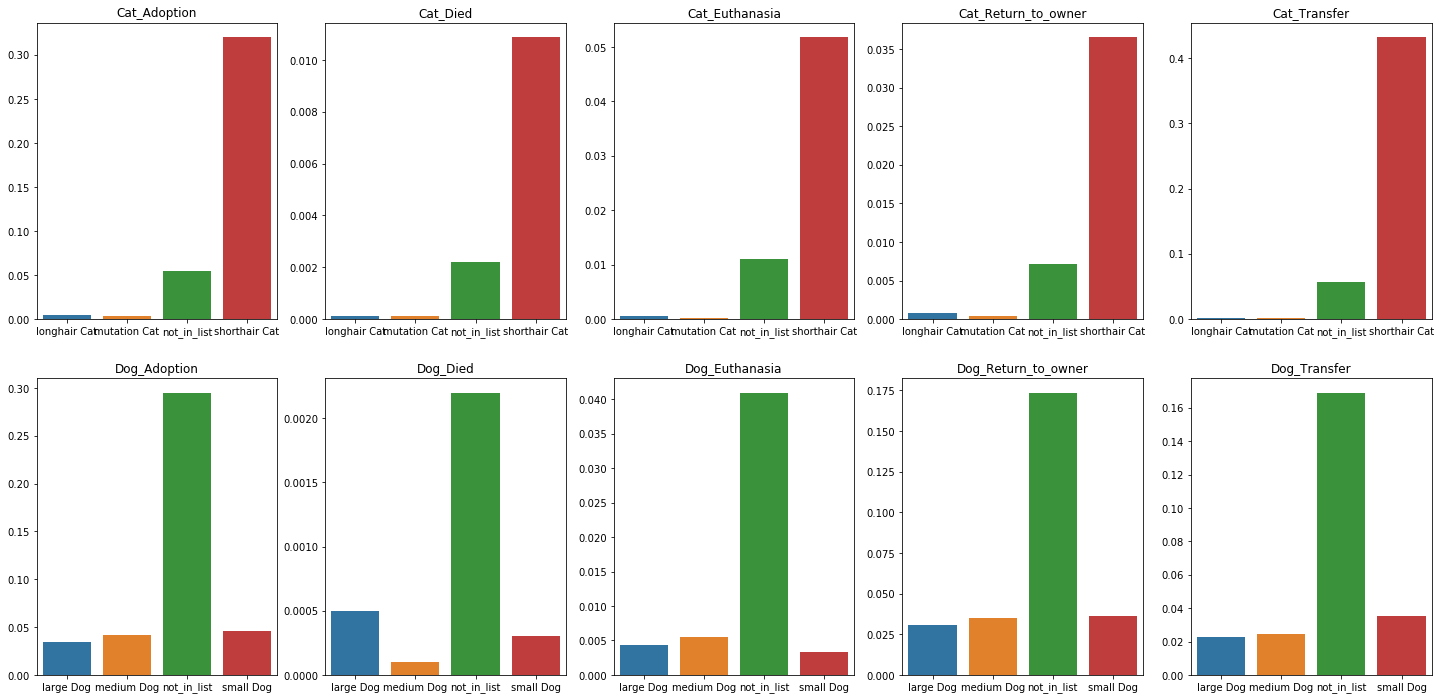

In [12]:
breed_type = []
for c in train_data.Breed:
    if type(c) == float:
        breed_type.append('Unknown')
        continue
    if 'Mix' in c:
        c = c[:c.rindex(' ')]
    if c in smallDog:
        breed_type.append('small Dog')
    elif c in mediumDog:
        breed_type.append('medium Dog')
    elif c in largeDog:
        breed_type.append('large Dog')
    elif c in shorthairCat:
        breed_type.append('shorthair Cat')
    elif c in longhairCat:
        breed_type.append('longhair Cat')
    elif c in mutationCat:
        breed_type.append('mutation Cat')
    else:
        breed_type.append('not_in_list')
train_data['Breed_type'] = breed_type

train_outcome_breed = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'Breed_type']).size()}).reset_index()
train_outcome_breed['Count_P'] = generate_Count_Prob(train_outcome_breed, 4)

generate_plot('Breed_type', train_outcome_breed)

Breed is not significantly promising, and there's a lot of missing data in it since all the breed type are messy and difficult to be identified. But I will just classify it by "mix" or "not mixed" in the final training, since pure breed maybe more popular than mixed, so "not mixed" should be less likely to die or euthanasia than "mixed" I guess.

### Analysis about Color

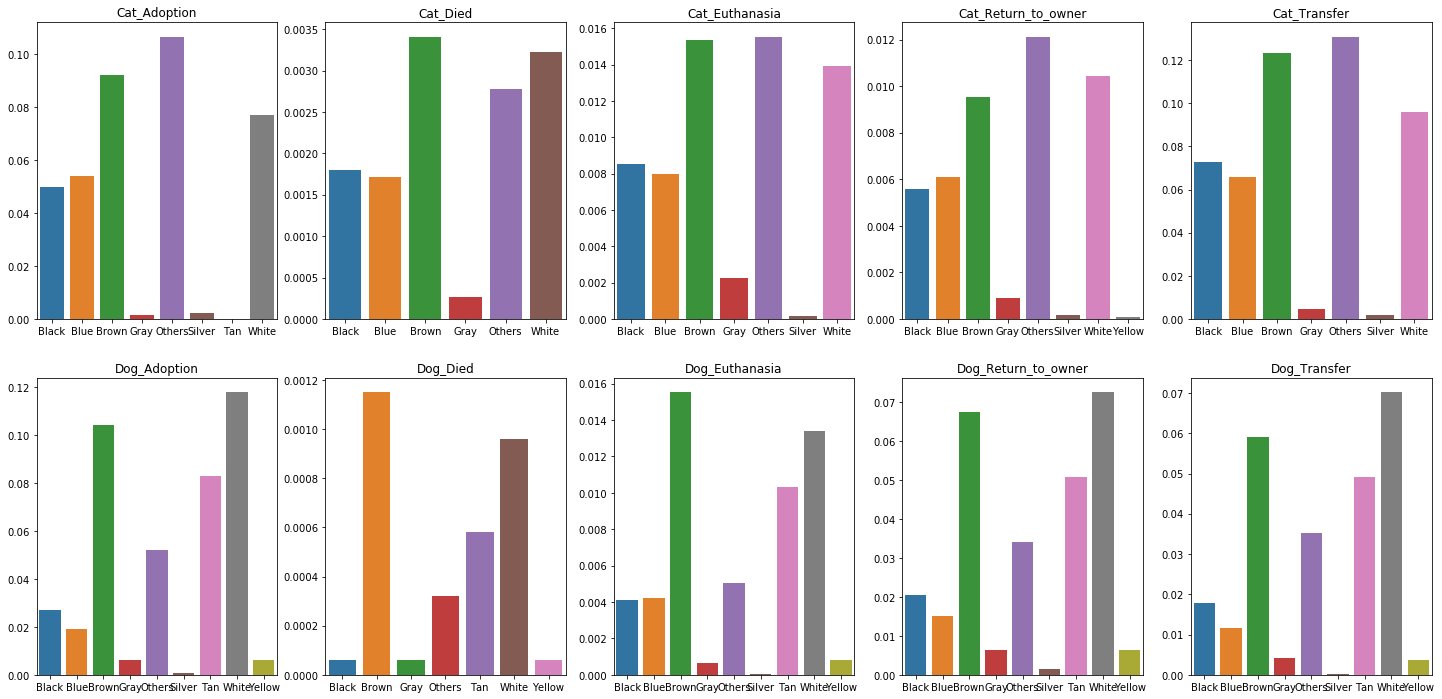

In [13]:
color_type = []
for c in train_data.Color:
    if 'Tan' in c:
        color_type.append('Tan')
    elif 'Silver' in c:
        color_type.append('Silver')
    elif 'Blue' in c:
        color_type.append('Blue')
    elif 'Gray' in c:
        color_type.append('Gray')
    elif 'Yellow' in c:
        color_type.append('Yellow')
    elif 'Brown' in c:
        color_type.append('Brown')
    elif 'White' in c:
        color_type.append('White')
    elif 'Black' in c:
        color_type.append('Black')
    else:
        color_type.append('Others')
train_data['Colors'] = color_type

train_outcome_color = pd.DataFrame({'Count' : train_data.groupby(["AnimalType", "OutcomeType", 'Colors']).size()}).reset_index()
train_outcome_color['Count_P'] = generate_Count_Prob(train_outcome_color, 5)
generate_plot('Colors', train_outcome_color)

The color is not really a significant variable too. The possible reason is that the adoption decision only based on owners’ preferences. Thus, it is not an affecting element. The final result got improved slightly after color being added. We also compared those animals if they have a mix color, which can be found in section 3.

### Analysis by date

The date is a pretty interesting variable to analysis. We tried to separate this variable by season and time of day. Besides, we assumed that the same goal could also be achieved by categorizing the time by weeks or months too. The results shown below are classified according to their seasons.

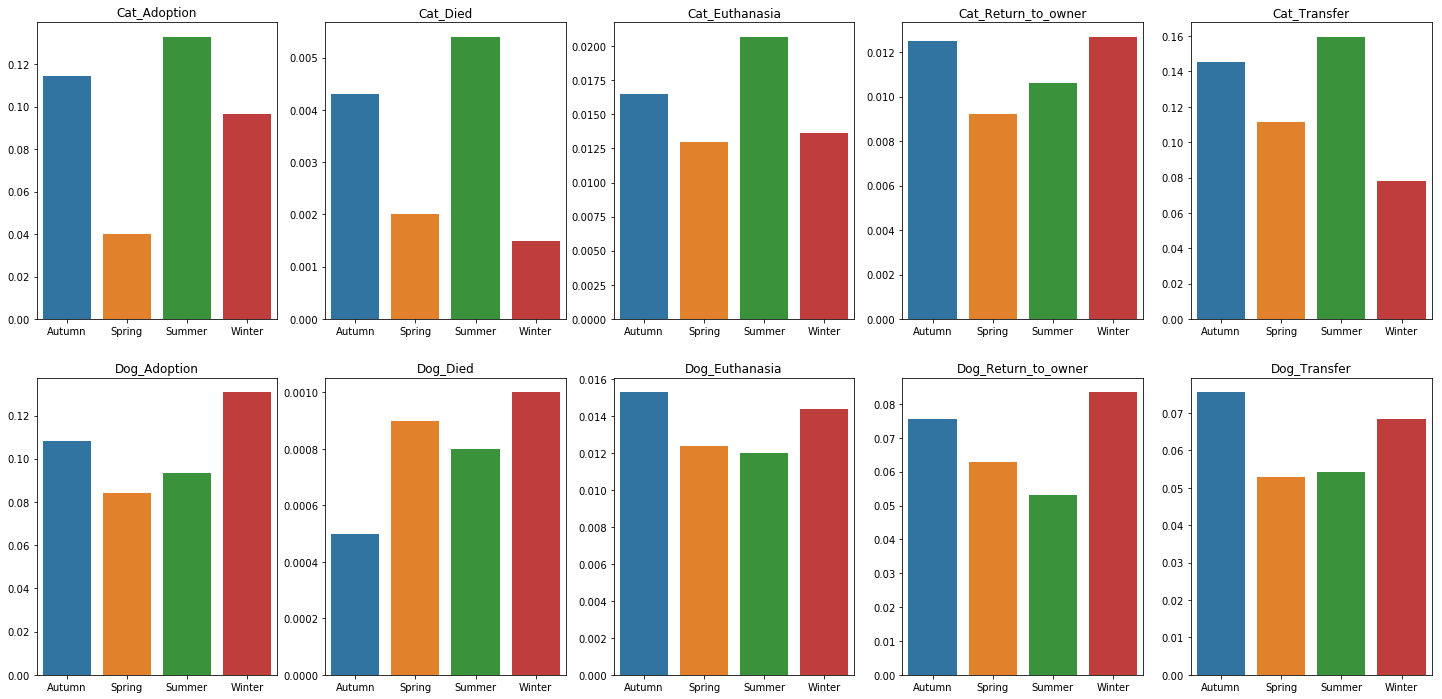

In [14]:
season_type = []
for c in train_data.DateTime:
# Seperate out the month from date and put them into right season.
    c = int(c.split(' ')[0].split('-')[1])
    if c < 3 or c == 12:
        season_type.append('Winter')
    elif c < 6:
        season_type.append('Spring')
    elif c < 9:
        season_type.append('Summer')
    elif c < 12:
        season_type.append('Autumn')
    else:
        season_type.append('Unknown')
train_data['Season'] = season_type

train_outcome_season = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'Season']).size()}).reset_index()
train_outcome_season['Count_P'] = generate_Count_Prob(train_outcome_season, 4)
generate_plot('Season', train_outcome_season)

As we can see, season actually affects the outcome types for different animal types, like summer is a predicting season for cat but autumn is more predicting for dog than other seasons. Thus we should include it in our modeling.

### Analysis by Time of Day

Time of Day is part of the analysis of "date", where I get 'hour' from the variable of date before checking the distribution of each outcome type porbabilities by plotting histograms.

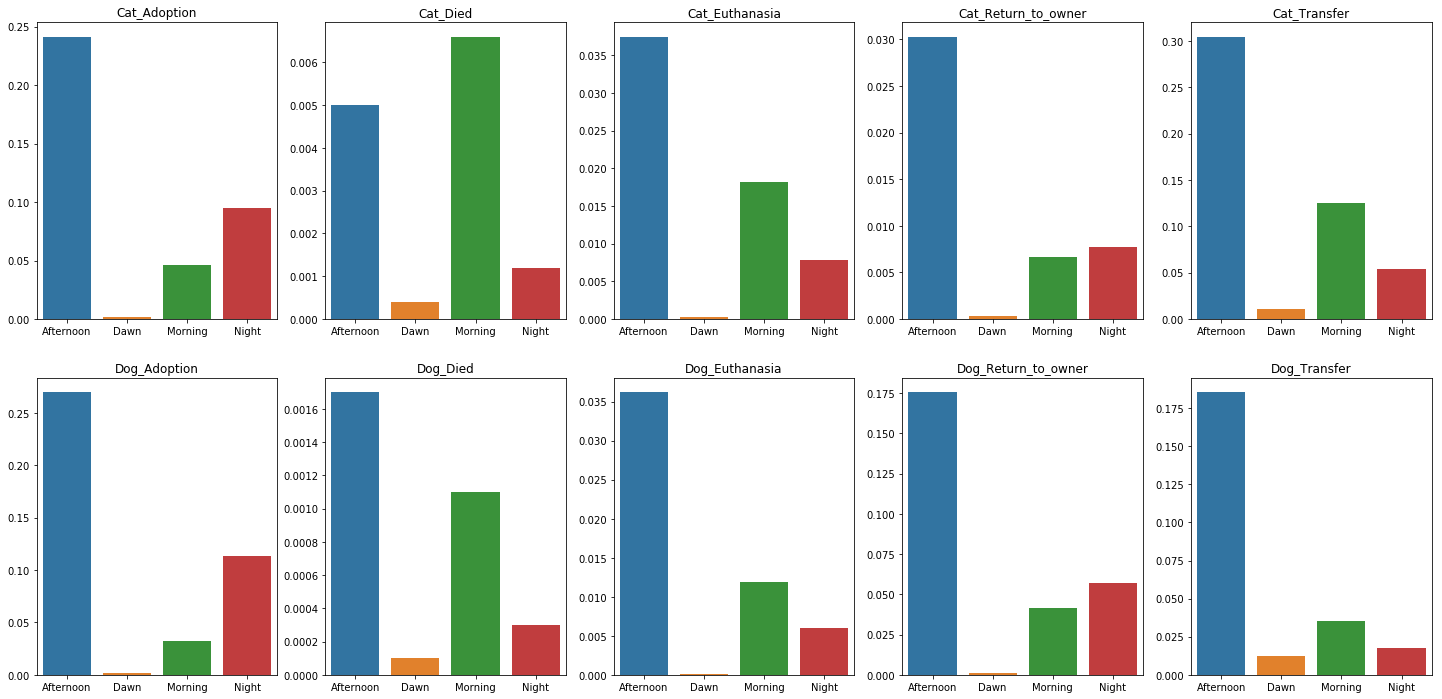

In [15]:
time_type = []
for c in train_data.DateTime:
    c = int(c.split(' ')[1].split(':')[0])
    if c < 6:
        time_type.append('Dawn')
    elif c < 12:
        time_type.append('Morning')
    elif c < 18:
        time_type.append('Afternoon')
    elif c < 24:
        time_type.append('Night')
    else:
        time_type.append('Unknown')
train_data['Time'] = time_type

train_outcome_time = pd.DataFrame({'Count' : train_data.groupby([ "AnimalType", "OutcomeType", 'Time']).size()}).reset_index()
train_outcome_time['Count_P'] = generate_Count_Prob(train_outcome_time, 4)
# train_outcome_time
generate_plot('Time', train_outcome_time)

Well afternoon is most of time when everything is happening, but in the moring is more likly for a cat to die. So compare to other variable is not very significant. 

### Analysis by Sex

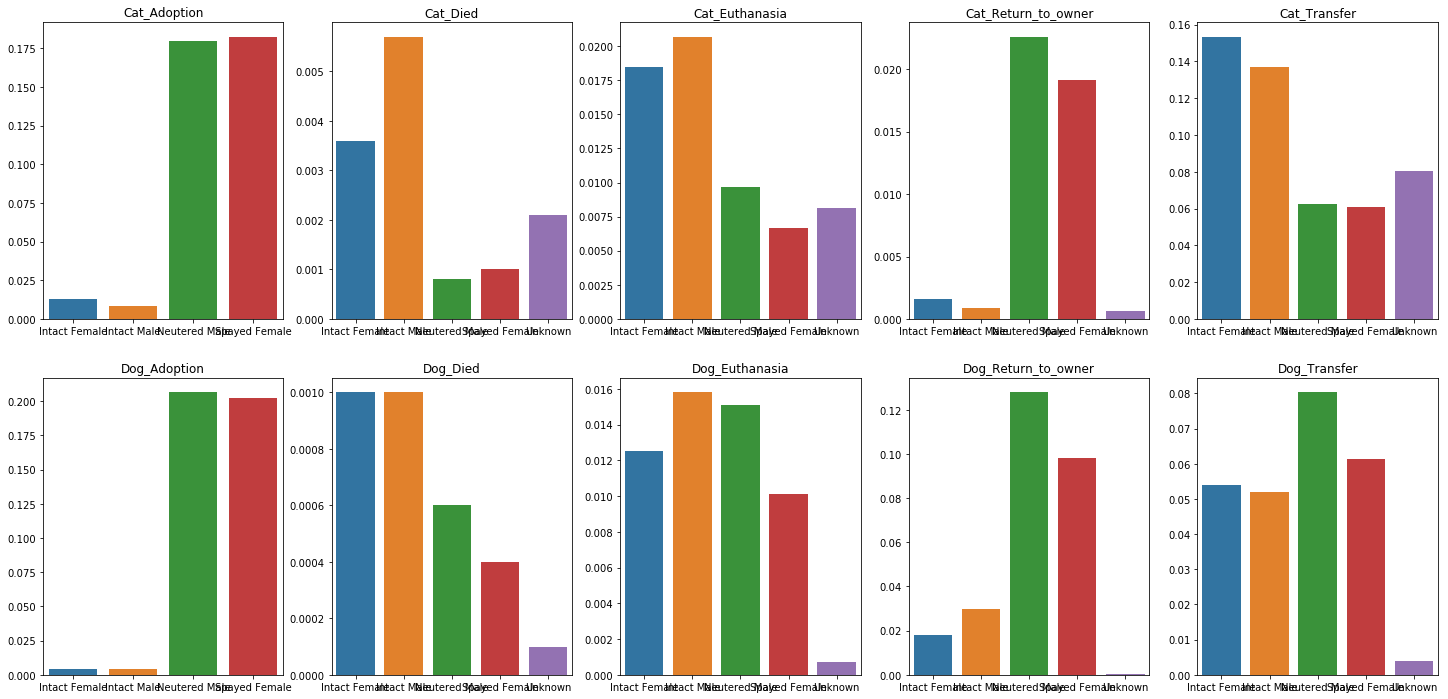

In [16]:
train_outcome_sex = pd.DataFrame({'Count' : train_data.groupby(["AnimalType", "OutcomeType", 'SexuponOutcome']).size()}).reset_index()
train_outcome_sex['Count_P'] = generate_Count_Prob(train_outcome_sex, 4)
generate_plot('SexuponOutcome', train_outcome_sex)

Sex is a pretty predictive variable. Based upon the histgrams above, neutered animal is way more likely to be adopted for both cats and dog. Well, neutered an animal can be pretty expensive, I guess if I have to choose one favorite cat from several candidates, I'll choose the one neutered. In addition, male and female does impact the outcome type, too.

### Analysis by Name
We all agree upon that pet names would affect the outcome type, but is it statistically impacting the outcome type in the training data?

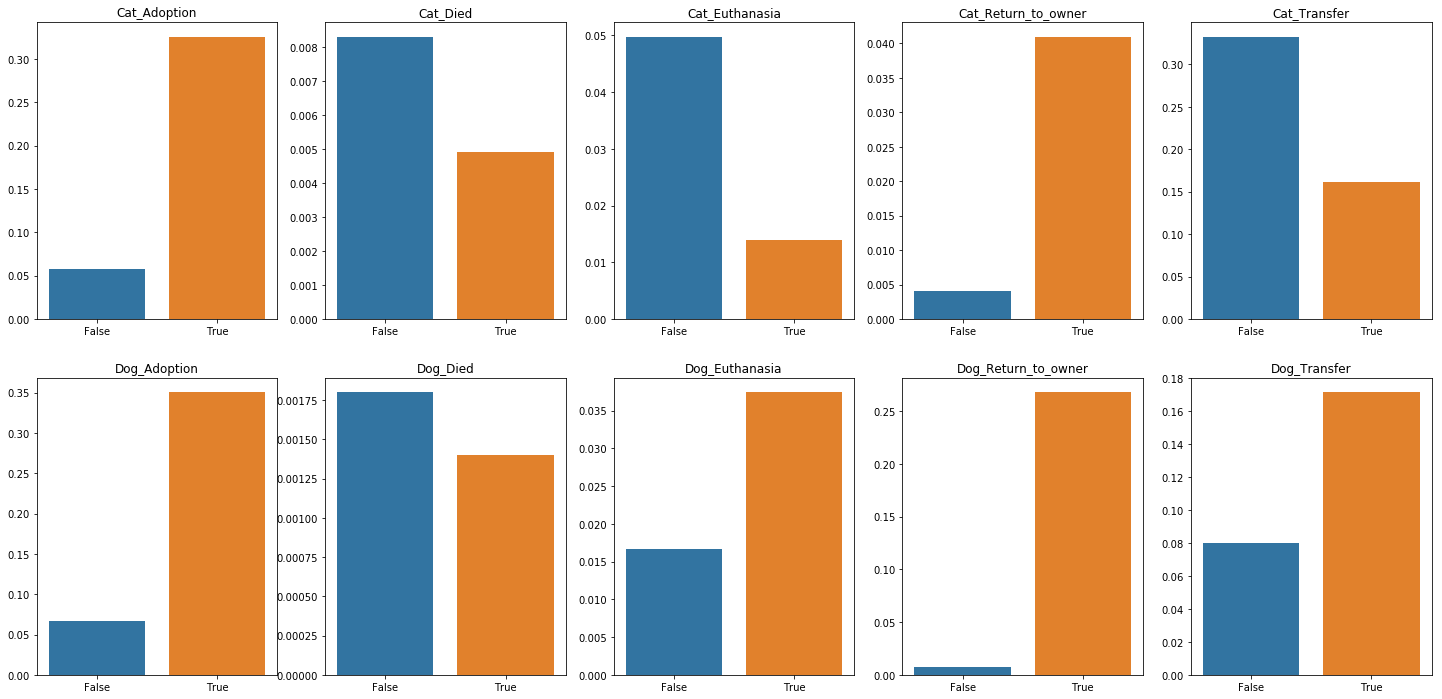

In [17]:
name_type = []
for c in train_data.Name:
    # There's large amount (about 30) of animal shows with the name 'X', 
    # so we assume 'X' is another way to indicate no name given,
    # although there's other names with only one charater other than 'X',
    # like Mr. C for a cat works for me.
    if type(c) == float or c == 'X':
        name_type.append('False')
    else:
        name_type.append('True')
train_data['HaveName'] = name_type
train_outcome_name = pd.DataFrame({'Count' : train_data.groupby(["AnimalType", "OutcomeType", 'HaveName']).size()}).reset_index()
train_outcome_name['Count_P'] = generate_Count_Prob(train_outcome_name, 4)

generate_plot('HaveName', train_outcome_name)

Result shows that a pet have a name has a way better chance to get adopted or returned to owner. Pets without a name has better chance to get euthanasia and died. So name should be involved in our model.

### Summary

As we can see, from all charts above, I think the promising features are:
- HasName (is animal have a name or not)
- isAdult (is animal older than one year old or not)
- Lifestage (in six ranges)
- Sex (Female or male, there's a missing sex data and we would just replace that with random sex, either male or female')
- Intact (is the animal intact or not)
- TimeOfDay (what time of the day when the outcome type happened)
- Season (in which season did the outcome happen)
- Month (in which month did the outcome happen)
- Is Mix (for color, indicating animal have more than one color or not)
- Is Mix (for breed, indicating animal have more than one breed or not)
- Colors (for color which fell in more categories than Is Mix for color above)

In the following section, we are going to analyze the classifying performacne of all these predictor variables and may be removing some less significant ones.

##### Feature importance

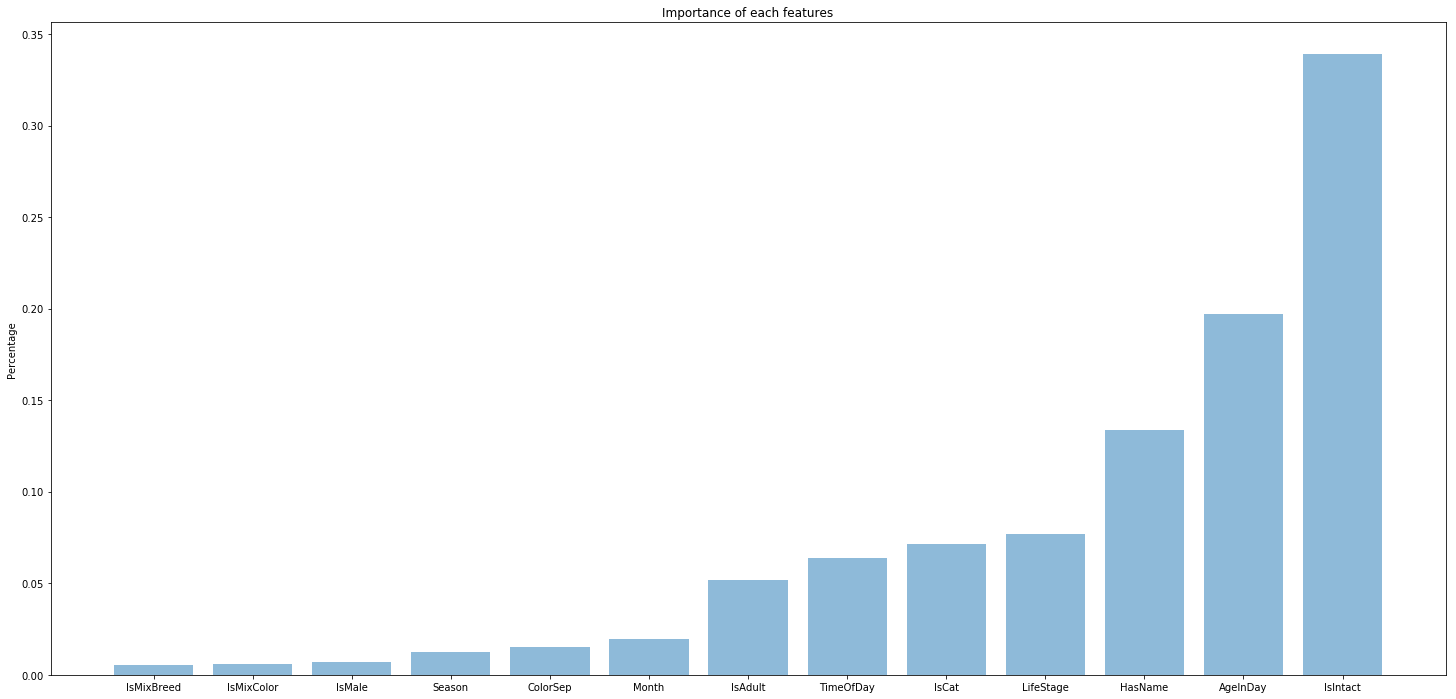

In [60]:
# We pick one of the output from random forest to generate the result
feature_import = array(list(randomForest[0][2]))
idx = np.argsort(feature_import)
feature_import = sort(feature_import)
y_pos = np.arange(len(feature_import))
plt.bar(y_pos, feature_import, alpha=0.5)
plt.xticks(y_pos, [cols[i+1] for i in idx])
plt.ylabel('Percentage')
plt.title('Importance of each features')
plt.show()

As we can see, Is the animal instact is actually the most important feature, follow by animal's age.

## Section II
## Algorithms Analysis

#### Extract Feature
In this part we extract all the feature we needed into numerical style.

In [19]:
def extract_features(data, test=False):
    cols = []
    if not test:
        data["Outcome"] = data["OutcomeType"].apply(outcomes)
        cols.append('Outcome')
    data['HasName'] = data['Name'].apply(has_name)
    cols.append('HasName')
    data['IsMale'] = data['SexuponOutcome'].apply(is_male)
    cols.append('IsMale')
    data['IsIntact'] = data['SexuponOutcome'].apply(is_intact)
    cols.append('IsIntact')
    data['AgeInDay'] = data['AgeuponOutcome'].apply(age_to_day)
    # Replace nan data to mean in age
    data['AgeInDay'].fillna(data['AgeInDay'].mean(), inplace=True)
    cols.append('AgeInDay')
    data['IsAdult'] = data['AgeInDay'].apply(lambda age_in_days: 0.0 
                                                   if age_in_days < 365 else 1.0)
    cols.append('IsAdult')
    data['LifeStage'] = data['AgeInDay'].apply(inLife)
    cols.append('LifeStage')
    data['TimeOfDay'] = data['DateTime'].apply(get_time)
    cols.append('TimeOfDay')
    data['Season'] = data['DateTime'].apply(get_season)
    cols.append('Season')
    data['Month'] = data['DateTime'].apply(get_month)
    cols.append('Month')
    data['IsMixBreed'] = data['Breed'].apply(is_Mix)
    cols.append('IsMixBreed')
    data['IsMixColor'] = data['Color'].apply(is_Mix_C)
    cols.append('IsMixColor')
    data['ColorSep'] = data['Color'].apply(color_sep)
    cols.append('ColorSep')
    data['IsCat'] = data['AnimalType'].apply(isCat)
    cols.append('IsCat')
    return data, cols

In [20]:
# Below is about 13 help function that we used to seperate the data.
# Extract animal type, cat is 1 and dog is 0
def isCat(animal_type):
    if animal_type == 'Cat':
        return 1.0
    else:
        return 0.0

In [21]:
# Extact color type.
def color_sep(c):
    if 'Tan' in c:
        return 1
    elif 'Silver' in c:
        return 2
    elif 'Blue' in c:
        return 3
    elif 'Gray' in c:
        return 4
    elif 'Yellow' in c:
        return 5
    elif 'Brown' in c:
        return 6
    elif 'White' in c:
        return 7
    elif 'Black' in c:
        return 8
    else:
        return 9

In [22]:
# Extract color type, where if there more than one color exist, return 1.
def is_Mix_C(color):
    if '/' in color:
        return 1.0
    else:
        return 0.0

In [23]:
# Extract breed type, see if it's a mix breed or not. 
def is_Mix(breed):
    if 'Mix' in breed or '/' in breed:
        return 1.0
    else:
        return 0.0

In [24]:
# Life stage according to the range we have in section 1, lifestages.
def inLife(age):
    if age < 365/2:
        return 1
    elif age < 365*3:
        return 2
    elif age < 365*7:
        return 3
    elif age < 365*11:
        return 4
    elif age < 365*15:
        return 5
    else:
        return 6

In [25]:
# Extract outcome type into number
def outcomes(outcomeType, oc = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']):
    return oc.index(outcomeType)

In [26]:
# Extract name feature, which have name is 1.0, otherwise is 0.0
def has_name(name):
    if type(name) == float or name == 'X':
        return 0.0
    else:
        return 1.0

In [27]:
# function to check is sex male, which unknown will return .5
def is_male(sex):
    if sex == 'Unknown' or type(sex) == float:
        return int(round(random.random(), 0))
    if 'Male' in sex:
        return 1.0
    elif 'Female' in sex:
        return 0.0

In [28]:
# function to check is animal intact, which unknown will return .5
def is_intact(sex):
    if sex == 'Unknown' or type(sex) == float:
        return int(round(random.random(), 0))
    elif 'Intact' in sex:
        return 1.0
    else:
        return 0.0

In [29]:
# Transfer age to days. 
def age_to_day(time):
    if type(time) == float:
        return nan
    c = time.split(' ')
    if c[1] == 'month' or c[1] == 'months':
        return int(c[0]) * 30.0
    elif c[1] == 'year' or c[1] == 'years':
        return int(c[0]) * 365.0
    elif c[1] == 'week' or c[1] == 'weeks':
        return int(c[0]) * 7.0
    else:
        return float(c[0])

In [30]:
# From date extract it into month
def get_month(time):
    c = int(time.split(' ')[0].split('-')[1])
    return c

In [31]:
# From date extract it into season.
def get_season(time):
    c = int(time.split(' ')[0].split('-')[1])
    if c < 3 or c == 12:
        return 1.0
    elif c < 6:
        return 0.25
    elif c < 9:
        return 0.5
    elif c < 12:
        return 0.75
    else:
        return 0.0

In [32]:
# From date extract into time of day.
def get_time(time):
    c = int(time.split(' ')[1].split(':')[0])
    if c < 6:
        return 0.25
    elif c < 12:
        return 0.5
    elif c < 18:
        return 0.75
    else:
        return 1.0

#### Generate Test and true data

In [33]:
# We will use Stratified K Fold method to randomly seperate the train data for performance analysis.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

In [34]:
skf=StratifiedKFold(n_splits=5, shuffle=True)
# Extract the need features from data
data, cols = extract_features(train_data)
# Seperate the data in to train part and target part
data_train = data.loc[:, cols].drop('Outcome', axis=1).as_matrix()
target = data['Outcome'].as_matrix()
# Use skf to random seperate the data into five different set.
train_set = []
test_set = []
for train_idx, test_idx in skf.split(data, target):
    X_train, X_test = data_train[train_idx], data_train[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    train_set.append((X_train, y_train))
    test_set.append((X_test, y_test))

In [35]:
# transfer the train and test data back to pandas format for better visualization
X_train_table = []
y_train_table = []
X_test_table = []
y_test_table = []
for i in range(len(train_set)):
    X_train_table.append(pd.DataFrame.from_records(train_set[i][0], columns=cols[1:]))
    y_train_table.append(train_set[i][1])
for i in range(len(test_set)):
    X_test_table.append(pd.DataFrame.from_records(test_set[i][0], columns=cols[1:]))
    y_test_table.append(test_set[i][1])

In [36]:
# Help function to check performance and logloss.
def performance_count(predicts, logloss = False): 
    avg = []
    loss = [0]
    for idx, predict in enumerate(predicts):
        count = 0
        if logloss:
            predict_prob = predict[1]
            predict = predict[0]
        for i, p in enumerate(predict):
            # print int(p), y_test_table[idx][i]
            if int(round(p)) == y_test_table[idx][i]:
                count += 1
        avg.append(float(count) / len(predict))
        if logloss:
            loss.append(log_loss(y_test_table[idx], predict_prob))
        print 'Match Percentage:', round(avg[-1] * 100, 2), '%', 'Log loss:', loss[-1], '\n'
    print 'Average Match Percentage:', round(sum(avg)*100/5.0, 2), '%', 'Average Log loss:', sum(loss)/5.0, "\n"
    return avg, loss

#### LinearRegression

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
def linearReg(X_train, y_train, X_test):
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

In [39]:
linear = []
for i in range(len(X_train_table)):
    linear.append(linearReg(X_train_table[i], y_train_table[i], X_test_table[i]))
linear_avg, linear_loss = performance_count(linear)

Match Percentage: 11.39 % Log loss: 0 

Match Percentage: 10.6 % Log loss: 0 

Match Percentage: 10.83 % Log loss: 0 

Match Percentage: 10.68 % Log loss: 0 

Match Percentage: 10.95 % Log loss: 0 

Average Match Percentage: 10.89 % Average Log loss: 0.0 



First algorithm poped into my mind is linear regression, which as we can see it's only about 10% of the train result matThe first algorithm we tried to fit is linear model, which turned out to be not very efficient with only about 10% of the predicttion match the true outcome type in the test data. Hence we are dropping this model in our final report.ch the test. I guess we are not going to consider it into the final submission.

#### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
def LogRegression(X_train, y_train, X_test):
    clf = LogisticRegression(random_state=1, max_iter=1000)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf.predict_proba(X_test)

In [42]:
logistic = []
for i in range(len(X_train_table)):
    logistic.append(LogRegression(X_train_table[i], y_train_table[i], X_test_table[i]))
logistic_avg = performance_count(logistic, logloss=True)

Match Percentage: 62.9 % Log loss: 0.894804286212 

Match Percentage: 61.55 % Log loss: 0.920122029162 

Match Percentage: 63.57 % Log loss: 0.885727125086 

Match Percentage: 63.26 % Log loss: 0.893459401858 

Match Percentage: 62.87 % Log loss: 0.899377973834 

Average Match Percentage: 62.83 % Average Log loss: 0.89869816323 



Logloss is what we used in our first submission. With defualt parameters in LogisticRegression, the result performed 0.903 for the logloss. which is not that bad but still can be improved. Please see details in our submission report.

#### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
def RandomForest(X_train, y_train, X_test):
    clf = RandomForestClassifier(n_estimators=278,
                                 min_samples_split=100, 
                                 min_samples_leaf=5,
                                 random_state=0)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf.predict_proba(X_test), clf.feature_importances_

In [45]:
randomForest = []
for i in range(len(X_train_table)):
    randomForest.append(RandomForest(X_train_table[i], y_train_table[i], X_test_table[i]))
randomForest_avg = performance_count(randomForest, logloss=True)

Match Percentage: 65.54 % Log loss: 0.828747013832 

Match Percentage: 64.28 % Log loss: 0.857834176553 

Match Percentage: 66.38 % Log loss: 0.827844170419 

Match Percentage: 65.82 % Log loss: 0.835344266912 

Match Percentage: 65.19 % Log loss: 0.837440101471 

Average Match Percentage: 65.44 % Average Log loss: 0.837441945837 



Random forest is currently the best model, which we modeled with in all submissions except the very first one. We tried multiple randomforest models with different parameters along with different combinations of features. Please see details in our submission report. 

#### Analysis On Random Forest 
After we decide to use random forest, it's a good idea to make sure which parameter is right for us. Here's the plot compare in between different max_feature and n_estimators. Which from final report, we figure that sqrt and log2 don't really effect our model and n_estimators = 279 will return the best result.

In [58]:
from collections import OrderedDict

def get_oob_error(ensemble_clfs, min_=15, max_=300):
    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
    
    for label, clf in ensemble_clfs:
        for i in range(min_, max_ + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train_table[0], y_train_table[0])

            # Record the OOB error for each setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))
    return error_rate

# Help function to generate the plot
def get_plot(error_rate, tests=[], xlabel='n_estimators', min_=15, max_=300):
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        tests.append((label, xs, ys))
        plt.plot(xs, ys, label=label)

    plt.xlim(min_, max_)
    plt.xlabel(xlabel)
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    
#     for lab, x, y in tests:
#         print lab, 'error:', min(y), 'at', x[argmin(y)]

In [50]:
# Test on max_features
test_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, max_features="sqrt",
                               oob_score=True, random_state=0)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, random_state=0)),
    ("RandomForestClassifier, max_features='None'",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, random_state=0))
]
error_rate = get_oob_error(test_clfs, min_=15, max_=300)

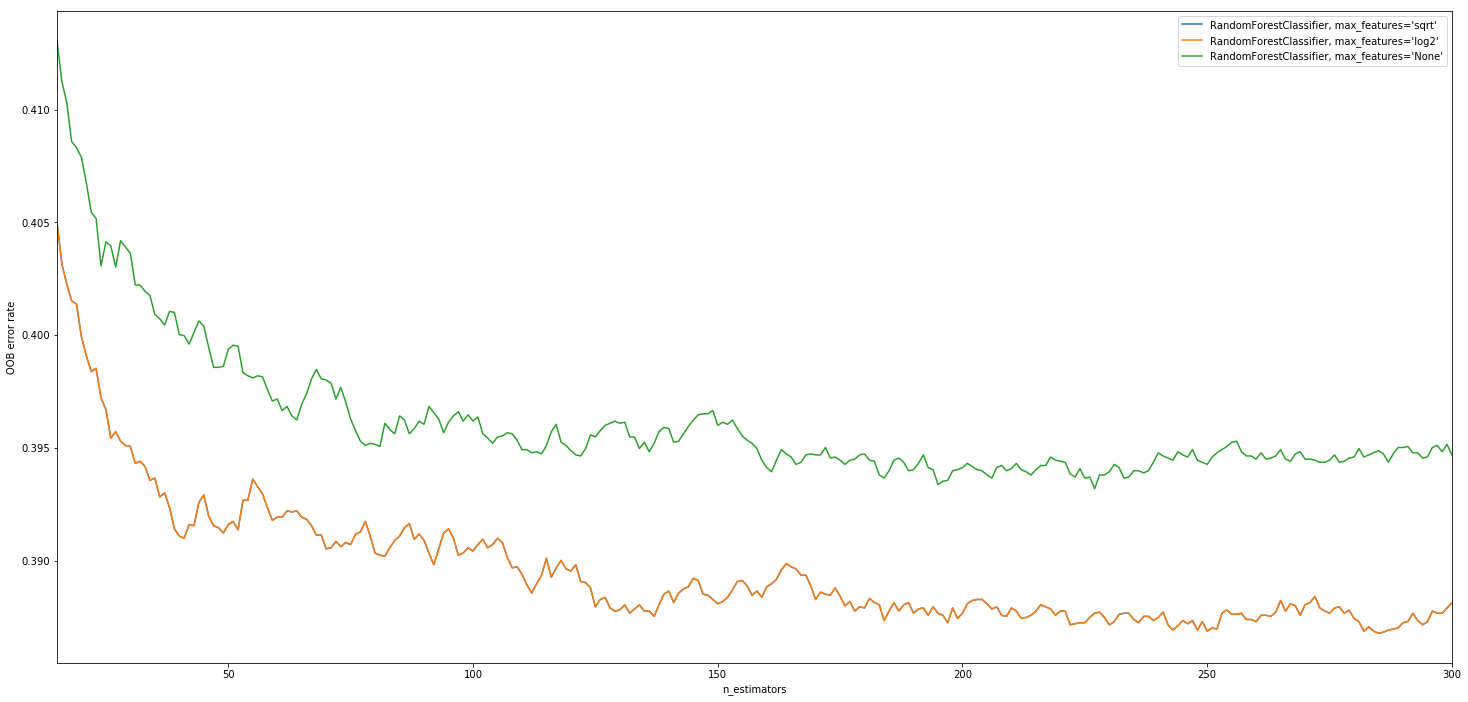

In [59]:
get_plot(error_rate)

## Section III
## Actual Performance
This section is just code to generate the predicting results from train and the their corresponding true outcome type in test data, and then saving the data into a csv file.

In [54]:
X_train, train_cols = extract_features(train)
y_train = X_train['Outcome']
X_train = X_train.loc[:, train_cols].drop('Outcome', axis=1)

X_test, test_cols = extract_features(test, test=True)
X_test = X_test.loc[:, test_cols]

#### Logistic Regression
- First Submission, 0.903

In [55]:
oc = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

In [56]:
logistic_res = LogRegression(X_train, y_train, X_test)
logistic_res_table = pd.DataFrame.from_records(logistic_res[1], columns=oc)
# Hard code 11457 is test set volume
logistic_res_table.insert(0, 'ID', range(1, 11457))
# Save into csv form
CSV_FILE='/Users/JohnnyLiu/Desktop/Logistic_res.csv'
logistic_res_table.to_csv(CSV_FILE, index=False)

#### Random Forest
- Second Submission, 0.8605
- Third submission, 0.85541
- Fourth submission, 0.85375 Add color and mix
- Fifth submission, 0.81686 #687 place

In [57]:
RandomForest_res = RandomForest(X_train, y_train, X_test)
RandomForest_res_table = pd.DataFrame.from_records(RandomForest_res[1], columns=oc)
RandomForest_res_table.insert(0, 'ID', range(1, 11457))
# Save into csv form
CSV_FILE='/Users/JohnnyLiu/Desktop/RandomForest_res.csv'
RandomForest_res_table.to_csv(CSV_FILE, index=False)

## SECTION IV
## Submission Report

Here is the detail report about our submission detail.

First Submission:
    - Algoirthm: Logistic Regression:
    - Logloss: 0.903
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season'.
    - Detail: This submission is the first attempt to check our model efficiency. At this point, we were using the features shown above. Compared to the model of Random Forest with no parameters, Logistic Regression has a better logloss score, than that of the random forest model (about 1.3) with the same features included.

Second Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.8605
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season'.
    - Detail: After the fisrt submission, we added some parameters to the random forest algorithm and the log loss score changed significanlty, which we submited again.

Third Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.85541
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season'.
    - Detail: Tried different parameters to get better result, run a lot of combinations of parameters to get the best one for our classification. Compared with the second submission, the only difference was parameters combination for the model.

Fourth Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.85375
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season', 'IsMixBreed', 'IsMixColor', 'ColorSep'.
    - Detail: We introduced three more features in our fourth submission, but the log loss score did not improve evidently.

Fifth Submission:
    - Algoirthm: Random Forest:
    - Logloss: 0.81686
    - Place: # 687
    - Features: 'HasName', 'IsMale', 'IsIntact', 'AgeInDay', 'IsAdult', 'LifeStage', 'TimeOfDay', 'Season', 'IsMixBreed', 'IsMixColor', 'ColorSep', 'IsCat'.
    - Detail: In the final submission, we introduced the animal type as one additional feature. We tried to train the data for dags and cats seperatly at the very begining so we forget to include this indicator in our final model. According to the outputs above, the log loss score significant increased by adding this classifier, and this submission made us raking at # 687 in the leaderboard of this competition.

Things changed but not submit:
    - We tried to use less features than that we have in the train data to test about overfitting. Based on the test results in section 2, although the log loss score didn't change much, it did offer us some idea about the importance of each feature.
    - We tried other algorithms but none of them have better perforamce than that of Random Forest, so we just hold on the model of Random Forest in our submissions.